# Створення та збереження моделі

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import sklearn
from pathlib import Path
from keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import zipfile
import shutil
from keras.applications import ResNet50V2
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = './chest_xray/train' # шлях до навчальних даних
#train_dir = './newtrain'
test_dir = './chest_xray/test' # шлях до тестових даних
val_dir = './chest_xray/val' # шлях до

In [13]:
img_width, img_height = 224, 224

batch_size = 16
val_batch_size = 2
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range = 40
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_dir,
                                                   batch_size=batch_size,
                                                   target_size =(img_width, img_height),
                                                   class_mode = "binary" )

val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=val_batch_size,
                                                target_size = (img_width, img_height),
                                                class_mode = "binary")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size = (img_width, img_height),
                                                  class_mode = "binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
ResNet50V2_base_model = ResNet50V2(input_shape=train_generator.image_shape, include_top=False, weights='imagenet')

for layer in ResNet50V2_base_model.layers:
    layer.trainable = False

In [15]:
ResNet50V2_model = Sequential([
    ResNet50V2_base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
ResNet50V2_model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Тест збереженої моделі

In [16]:
ResNet50V2_model.load_weights("ResNet50V2_project_model1.h5")

In [17]:
print(ResNet50V2_model.evaluate(test_generator))

39/39 [==============================] - 70s 2s/step - loss: 0.4359 - accuracy: 0.8606
[0.4358680546283722, 0.8605769276618958]


In [11]:
model = load_model('test_accuracy_89.h5')

In [ ]:
print(model.evaluate(test_generator))

# Розпізнавання власних зображень

In [18]:
folder_path = 'own images'

img_array = []
label_array = []

# Отримання списку файлів у папці
files = os.listdir(folder_path)
print(files)
for file_name in files:
  file_path = os.path.join(folder_path, file_name)
  if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
    img_array.append(image.load_img(file_path, target_size=(img_width, img_height)))
    label_array.append(file_name)

['n1.jpeg', 'n2.jpeg', 'n3.jpeg', 'n4.jpeg', 'n5.jpeg', 'p1.jpeg', 'p2.jpeg', 'p3.jpeg', 'p4.jpeg', 'p5.jpeg']


In [19]:
count = 0
pred_arr = []
for img in img_array:
  # Converting the image to a numpy array
  x = image.img_to_array(img)
  x = x.reshape((img_width, img_height,3)).astype('float32')
  # Image normalization
  x /= 255
  x = np.expand_dims(x, axis=0)
  prediction = ResNet50V2_model.predict(x)
  if(prediction>0.5):
    pred_arr.append(f"{label_array[count]} : {prediction} == pneum")
  else:
    pred_arr.append(f"{label_array[count]} : {prediction} == norma")
  count += 1

1/1 [==============================] - 0s 114ms/step


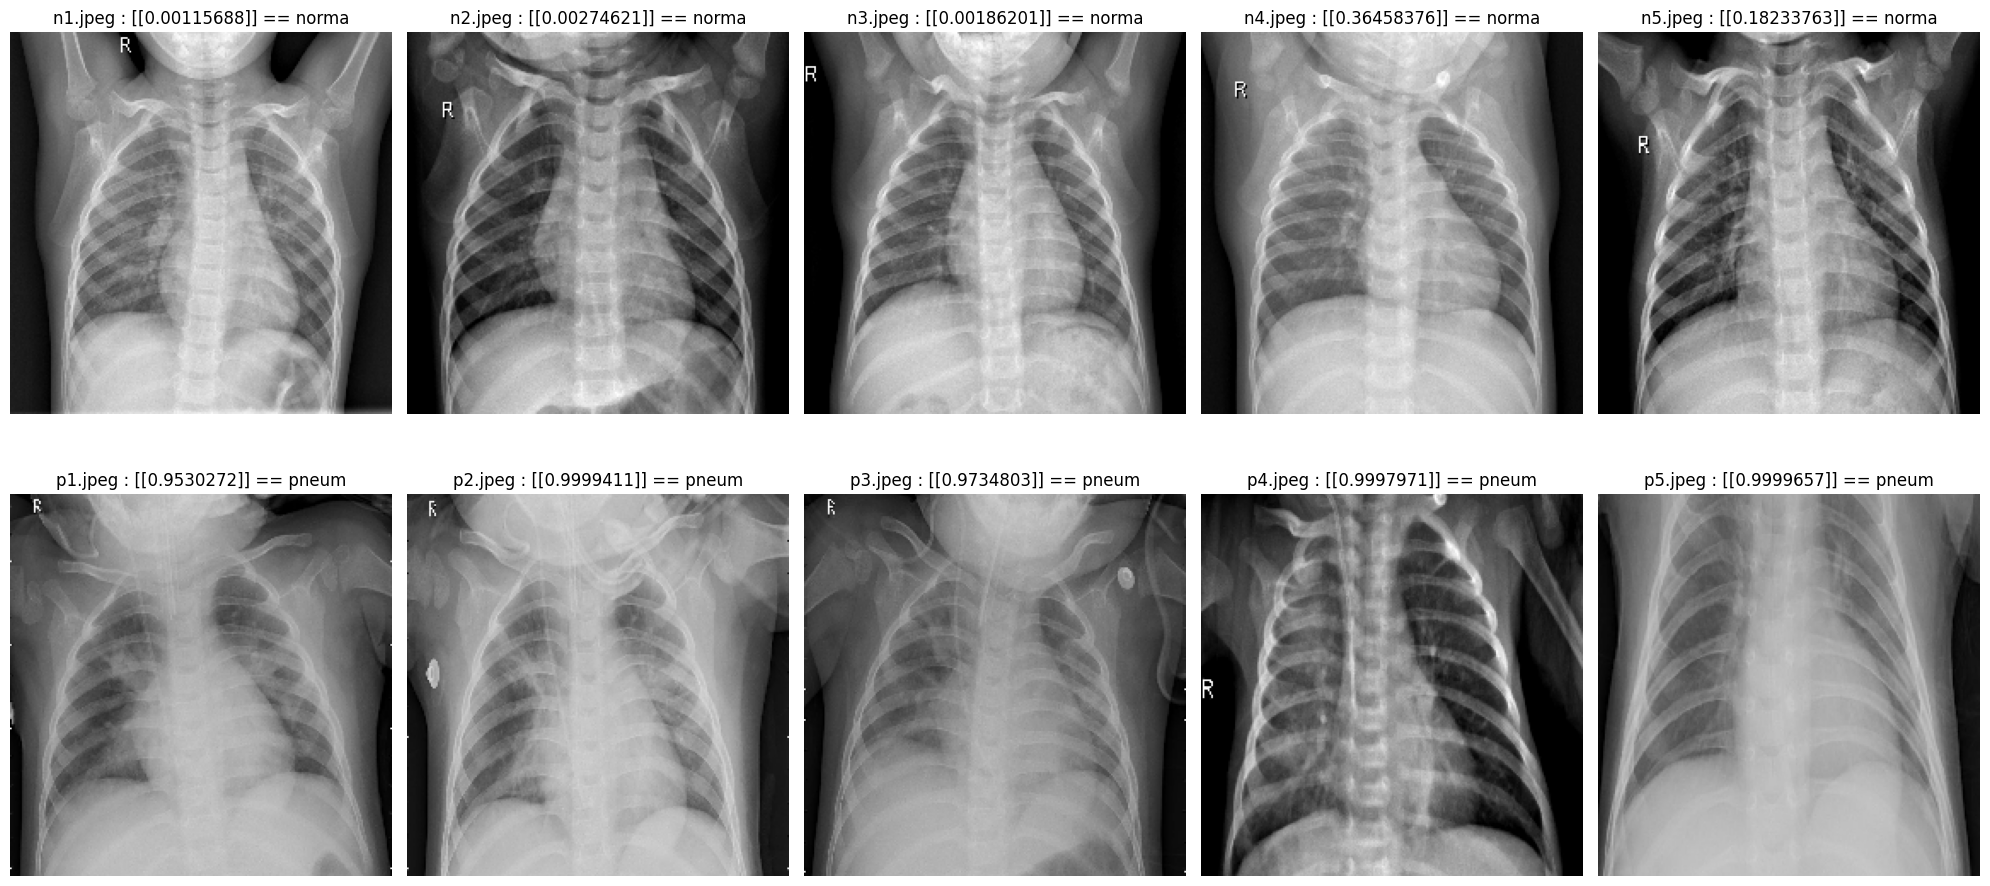

In [20]:
if len(pred_arr) == len(img_array):
  plt.figure(figsize=(20, 10))
  count = 0
  for i in range(len(pred_arr)):
    plt.subplot(2, 5, count + 1)
    plt.imshow(img_array[i].convert('RGBA'))
    plt.axis('off')
    plt.title(f"{pred_arr[i]}")
    count += 1
  plt.tight_layout()
  plt.show()

# Створення графічного інтерфейсу

In [21]:

def xrayClassification(img):
    x = image.img_to_array(img)
    x = x.reshape((img_width, img_height,3)).astype('float32')
    # Image normalization
    x /= 255
    x = np.expand_dims(x, axis=0)
    prediction = ResNet50V2_model.predict(x)
    print(prediction)
    img_class = "Normal" if prediction < 0.5 else "Pneumonic"
    return img_class

In [22]:
import gradio
from gradio.components import Image, Label

img = Image(shape=(img_width, img_height))
label = Label(num_top_classes=1)

interface = gradio.Interface(fn=xrayClassification,
                             title="Med app",
                             inputs=img,
                             outputs=label,
                             interpretation="default")
interface.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://242867c3370bc9c739.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "C:\Users\alex2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\routes.py", line 534, in predict
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alex2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alex2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\blocks.py", line 1550, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alex2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

1/1 [==============================] - 0s 170ms/step
[[0.09183531]]
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://242867c3370bc9c739.gradio.live
